# NTSB Feature Selection

This notebook examines the rates of missingness for each value in the master NTSB dataset, as well as population for dummy variables, allowing us to pare down features which may not be likely to be useful/predictive.

### Note: 
This notebook employs the **'missingno'** package, which can be installed with a "pip install missingno" command in your Terminal.
***


In [1]:
import pandas as pd
import missingno as mno
import matplotlib.pyplot as plt
import numpy as np

In [2]:
data = pd.read_csv("../data/ntsb/cleaned/master_train.csv")

data = data.loc[(data['ev_country']=='USA') & (data['ev_type']=='ACC')]
data.drop(columns=['ev_country', 'ev_type'], inplace=True)

### Drop columns we don't need

#### Notes 
- Since we don't want to drop columns based on their frequency in the test set, this is probably a temporary measure to simplify our exploration, but we can take it out once we have a model
- The following should be run __before__ drop infrequent values, which fills in missing entries

In [3]:
def drop_sparse_columns(data, threshold, safe_cols=None):
    '''
    Drops columns from data that do not contain at least a given proportion of non-empty entries
    
    Inputs
        data: pandas DataFrame
        threshold: float in [0,1], all columns with less than this proportion of non-empty entries are dropped
        safe_cols: list of names of columns that should not be dropped even if they are below the sparsity threshold
    Outputs
        data: same DataFrame with appropriate columns dropped
    '''
    # list of columns to drop if they are too sparse
    unsafe_cols = [col for col in data.columns if col not in safe_cols]

    for col in unsafe_cols:
        # calculate proportion of na entries in col
        prop_na = data[col].isna().sum() / len(data)
        
        # drop col if the column is too sparse
        if prop_na > 1 - threshold:
            data.drop(columns=col, inplace=True)
    
    return data

In [4]:
data = drop_sparse_columns(data, 0.8, safe_cols=['damage', 'acft_category', 'acft_make', 'acft_model'])

In [5]:
# Already processed
data.drop(columns=['Aircraft', 'Aircraft_Key', 'ev_id', 'finding_description'], inplace=True)

# Possible data leakage
data.drop(columns=['acft_fire', 'acft_expl'], inplace=True)

# Probably not relevant (ev_time seemingly boils down to light_cond)
data.drop(columns=['wx_dew_pt', 'type_fly', 'ev_time'], inplace=True)

# (Almost) all rows have same value
data.drop(columns=['certs_held', 'unmanned'], inplace=True)

### Handling missing values

Eventually when we impute values, I think we should do so __before__ dropping any columns / infrequent values of categorical variables because we may use that information in imputation even if we don't use it in modeling. E.g. if we only two occurences of a particular aircraft model, that could still be useful for imputing missing info about the aircraft.

#### `total_person_count`
We have some missing data for `total_person_count`, which can mostly be calculated, but:
1. there are a few (~10) cases where we're missing data for both aircraft in a multi-aircraft event. 
2. if `inj_tot_t` and aircraft-level counts are missing and the other event-level injury counts are 0, this does not necessarily indicate that there were only unmanned aircraft involved. It seems that the other event-level injury counts default to 0 when they are unknown, and only `inj_tot_t` is left blank in the dataset.

I found the following reasons why the injury counts might be unknown:
- Crash occurred outside of the USA --> no NTSB investigation
- Incident and not accident --> superficial investigation
- Aircraft damage was discovered in an inspection --> investigation could not determine whether injuries occurred

#### Filtering data
- I think we should filter out (a) events outside the USA and (b) non-accidents because of a high likelihood of sparse data. This leaves us with ~83% of the data. 
- If we do this, most of the variables now have well over 80% of the values present
- My gut is to filter before the train-test split, but I'm not certain that's right (or that it matters)

#### Other notes
- Oddly, `gust_kts` is 100% present but `wind_vel_kts` is ~20% missing. When `wind_vel_kts` is missing, `gust_kts` is 0 more than 99% of the time, which probably means that 0 is entered by default when it's unknown

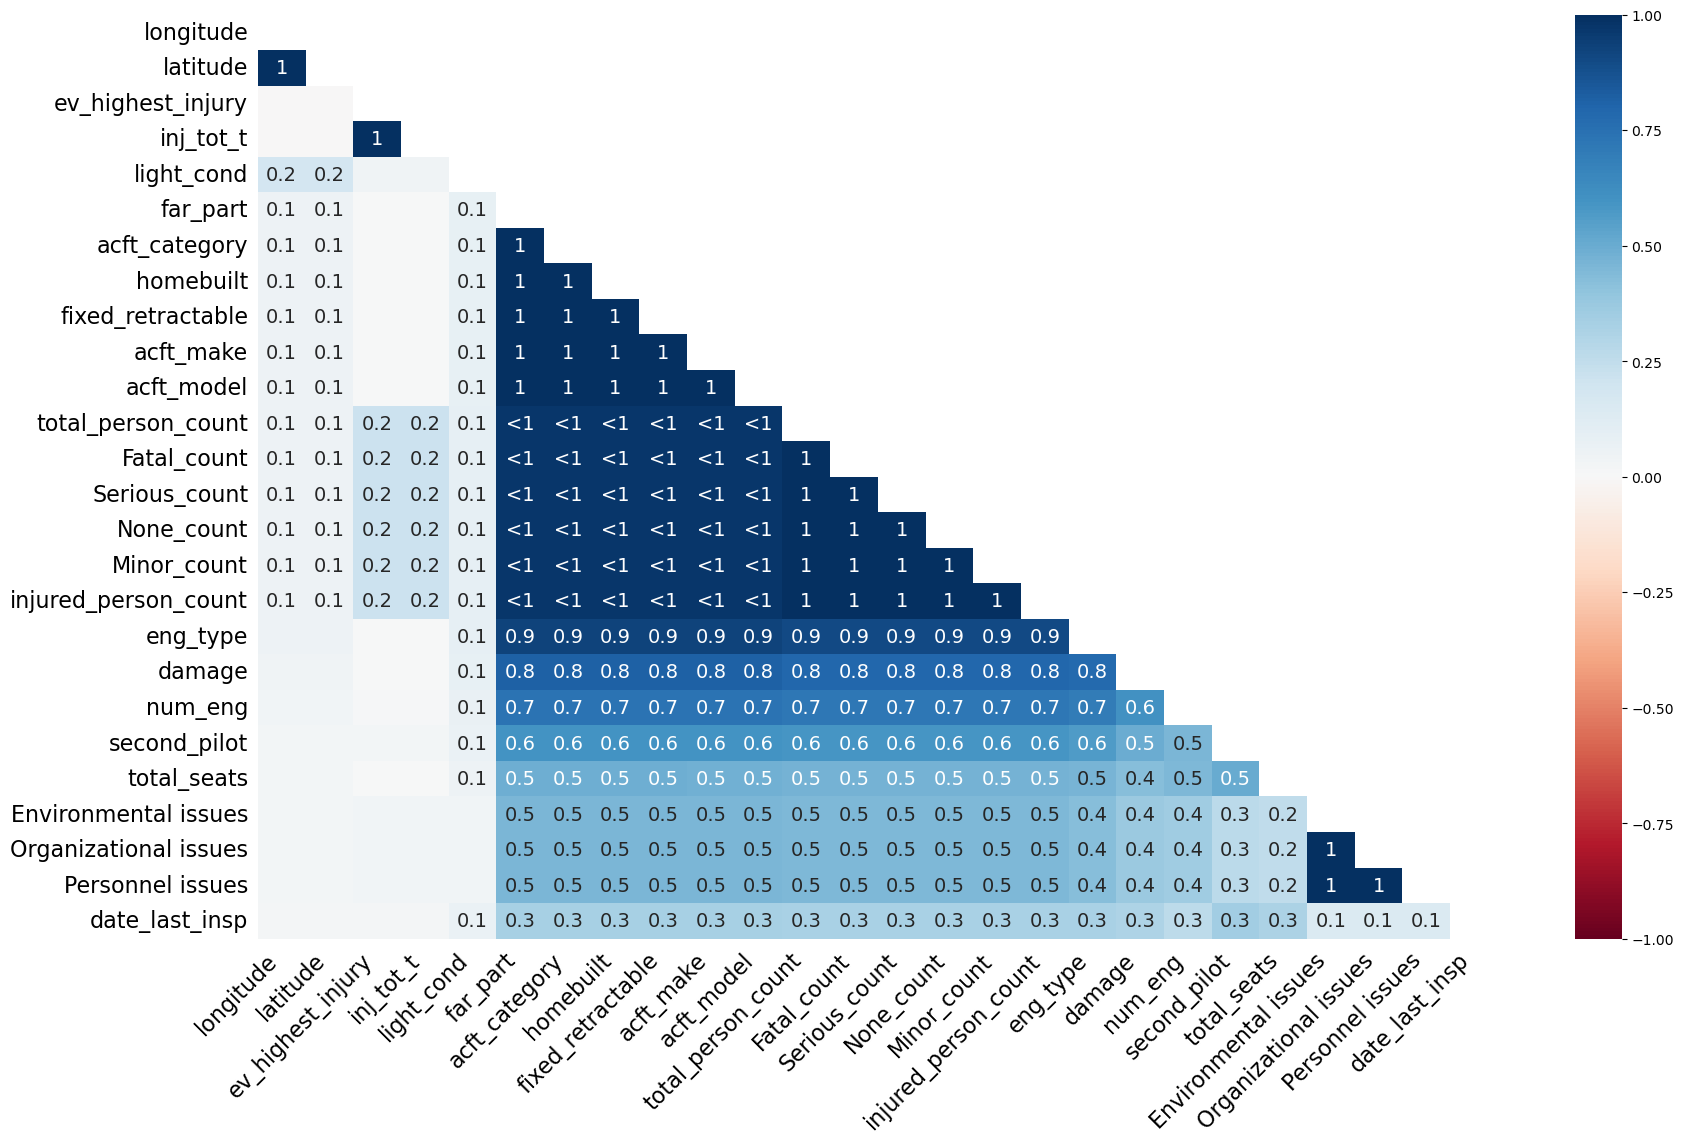

In [6]:
mno.heatmap(data, sort='descending')
plt.show()

### Imputing values

Categorical
- Target variables (does it ever make sense to impute a target variable, or should we just omit from the dataset / performance metrics?)
  - `damage`: guess based on injury severity 
  - `ev_highest_injury`: calculate from injury counts
- May be able to do something smarter than 'other/unknown' (but it may not be worth it; I'd recommend we start with 'other/unknown' and revisit if these variables seem important in initial model)
  - `acft_category`: after reducing categories, may be able to guess from number of people / engines
  - 
- All others: 'other/unknown'

Numerical
- Calculate from other data: `total_person_count`, `Minor_count`, `None_count`, `Serious_count`, `Fatal_count`, `injured_person_count`, `ev_highest_injury`, `inj_tot_t`
- `latitude`, `longitude`, `ev_time`: ??
- `Environmental issues`, `Organizational issues`, `Personnel issues`: impute 0
- `num_eng`
  - Determine from `acft_model` (only in small number of cases: only 44% of rows missing `num_eng` respectively have known `acft_model`) 
  - Guess based on number of passengers
  - Impute the mode / median

### Category reduction for categorical variables

#### Manual category reduction

Before we reduce infrequent values to 'other/unknown', there may be cases where we can combine categories in a more intelligent way:
- BroadPhaseOfFlight (what happened to this variable?)
- `acft_category`: group based on size?
- `far_part`: would require some research
- `light_cond`: maybe combine all conditions other than DAYL and NITE into a 'partial light' category (would have to check what all of the abbreviations mean)

#### Automated category reduction

We'll reduce categories by reassigning all categories with frequency $< \alpha$ to 'other/unknown' (for some $\alpha \in [0.01, 0.05]$)

Note: when we go to build the model, we'll have to make sure we're reducing categories based on their frequency in the training set and NOT based on their frequency in the test set

In [7]:
def reduce_categories_fill_na(data, columns, threshold):
    '''
    For each of the specified columns, find the values that occur with frequency lower than the threshold,
    and replace these values and missing values by 'other/unknown'.
    This is only intended for categorical variables
    
    Inputs
        data: pandas DataFrame
        columns: list of column names to simplify
        threshold: float in [0,1], frequency threshold for removing 
    Outputs
        data: pandas DataFrame
    '''

    freq_thresh = threshold * len(data)

    for col in columns:
        counts = data[col].value_counts()
        
        for i in counts.index:
            if counts[i] < freq_thresh:
                data.loc[data[col]==i, col] = 'other/unknown'
        
        data.loc[data[col].isna(), col] = 'other/unknown'

    return data

In [8]:
categorical_vars = ['light_cond', 'eng_type', 'far_part', 'acft_make', 'acft_category',
                    'homebuilt', 'fixed_retractable', 'second_pilot']
# Note: intentionally omitted 'ntsb_no', 'ev_highest_injury', 'Aircraft_ID', 'event_key', 
#                               'damage', 'acft_model'

new_data = reduce_categories_fill_na(data, categorical_vars, 0.03)

### Feature engineering

In [9]:
# Calculate number of people onboard and the proportion in each injury level

data['num_people_onboard'] = data['inj_tot_f'] + data['inj_tot_m'] + data['inj_tot_n'] + data['inj_tot_s']
data['prop_onboard_inj'] =  (data['num_people_onboard'] - data['inj_tot_n'])/ data['num_people_onboard']
data['prop_onboard_inj_m'] =  data['inj_tot_m'] / data['num_people_onboard']
data['prop_onboard_inj_s'] =  data['inj_tot_s'] / data['num_people_onboard']
data['prop_onboard_inj_f'] =  data['inj_tot_f'] / data['num_people_onboard']